# Modeling inhibitor molecules cancer protein kinases 
## Background
[Protein kinases](https://en.wikipedia.org/wiki/Protein_kinase) are enzymes involved in transferring a phosphate group to a protein. They can be understood as "activators" of protein via phosphorylation. All cells, including cancer cells, have a wide range of protein kinases involved in metabolism, synthesis of new molecules. One effective way to mitigate the proliferation of cancer cells is to deactivate central (upstream) protein kinases using inhibitor molecules, commonly used in chemotherapy (Bhular et al., 2018).

We are given a [dataset](https://www.kaggle.com/xiaotawkaggle/inhibitors) of molecules that can or cannot inhibit 8 different protein kinases involved in proliferation of cancer cells. The ability to inhibit is determined by the inhibition concentration needed to make half of the available kinases dysfunctional (IC50). On a molecular level, the denser is the environment with a molecule, the higher chance that it can bind to a kinase and induce a conformational on the kinase to alter its binding ability.

The format of this dataset is a molecule [fingerprint](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf) defined by RDKit hashed to a fixed-length vector of 8194 bits; hence, we have 8194 columns. Conceptually, each bit indicates the presense of a certain molecular structure (e.g. a carbonyl group). Thus, the closer the molecules are, the smaller the map distance between their footprints.

## Table of contents
- **Section 1**: Data processing
    - 1.0. Libraries
    - 1.1. Data loader
    - 1.2. Molecule visualizer
- **Section 2**: Simple inference scheme
    - 2.1. Modeling versus classification
    - 2.2. Prior and likelihood
    - 2.3. Bayesian Poisson factorization model
- **Section 3**: Improved inference with molecular features
    - 3.1. Rationale and new features
    - 3.2. Positive samples improved inference
    - 3.3. Negative samples improved inference
- **Section 4**: Classification validation
    - 4.1. Classification with inference
    - 4.2. Validation scheme
    - 4.3. Comparing models
- **Section 5**: Synthesis
    - 5.1 Discussion of models
    - 5.2 Next steps

## Section 1: Data processing
### 1.0. Libraries

In [13]:
import os
import io # for reading byte-stream images
import math
from PIL import Image
import requests

import pystan
import numpy as np
from scipy import sparse
from scipy import stats as sts

import h5py
import pandas as pd
import matplotlib.pyplot as plt

### 1.1. Data loader

In [43]:
root = './dataset'

class Dataset():
    def __init__(self, pk_name):
        # code for loading h5 file adapted from https://www.kaggle.com/xiaotawkaggle/inhibitors
        hf = h5py.File(os.path.join(root, pk_name + ".h5"), "r")
    
        ap = sparse.csr_matrix((hf["ap"]["data"], hf["ap"]["indices"], hf["ap"]["indptr"]), shape=[len(hf["ap"]["indptr"]) - 1, 2039])
        mg = sparse.csr_matrix((hf["mg"]["data"], hf["mg"]["indices"], hf["mg"]["indptr"]), shape=[len(hf["mg"]["indptr"]) - 1, 2039])
        tt = sparse.csr_matrix((hf["tt"]["data"], hf["tt"]["indices"], hf["tt"]["indptr"]), shape=[len(hf["tt"]["indptr"]) - 1, 2039])

        self.features = sparse.hstack([ap, mg, tt]).toarray() # the samples' features, each row is a sample, and each sample has 3*2039 features
        self.labels = hf["label"][()] # the label of each molecule
        self.chembl_ids = [str(name)[2:-1] for name in hf["chembl_id"][()]] # the name of each molecules
        
    def fetch_samples_with_label(self, label, start=0, end=None):
        filt_features = self.features[self.labels == label][start:end]
        filt_chembl_ids = self.chembl_ids[self.labels == label][start:end]
        filt_labels = self.labels[self.labels == label][start:end]
        
        return {
            "features": filt_features,
            "chembl_ids": filt_chembl_ids,
            "labels": filt_labels
        }
    
    def fetch_subset(self, start=0, end=None):
        filt_features = self.features[start:end]
        filt_chembl_ids = self.chembl_ids[start:end]
        filt_labels = self.labels[start:end]
        
        return {
            "features": filt_features,
            "chembl_ids": filt_chembl_ids,
            "labels": filt_labels
        }

In [40]:
pk_abbr = pd.read_csv(os.path.join(root, "abbr.csv"), header=None)
abbreviations = [abbr.lstrip() for abbr in pk_abbr[1]] # remove trailing space
pk_names = dict(zip(abbreviations, pk_abbr[0]))
pk_names

{'cdk2': 'Cyclin-dependent kinase 2',
 'egfr_erbB1': 'Epidermal growth factor receptor erbB1',
 'gsk3b': 'Glycogen synthase kinase-3 beta',
 'hgfr': 'Hepatocyte growth factor receptor',
 'map_k_p38a': 'MAP kinase p38 alpha',
 'tpk_lck': 'Tyrosine-protein kinase LCK',
 'tpk_src': 'Tyrosine-protein kinase SRC',
 'vegfr2': 'Vascular endothelial growth factor receptor 2'}

In [41]:
# initialize dataset
pk_datasets = {}
for pk_name in pk_names.keys():
    pk_datasets[pk_name] = Dataset(pk_name)

### 1.2. Molecule visualizer

In [37]:
chembl_api_link = 'https://www.ebi.ac.uk/chembl/api/data/image'

def display_molecules(chembl_ids, labels): # list of strings
    num_cols = 5
    num_rows = math.ceil(len(chembl_ids) / num_cols)
    plt.figure(figsize=(20, num_rows * 4), dpi=330)
               
    for idx, molec in enumerate(chembl_ids):
        plt.subplot(num_rows, num_cols, idx + 1)
        molec_url = os.path.join(chembl_api_link, molec)
        image_bytes = requests.get(molec_url).content
        image = np.array(Image.open(io.BytesIO(image_bytes)))
        plt.imshow(image)
        plt.axis('off')
        plt.title(molec + ': ' + str(labels[idx]))
               
    plt.show()

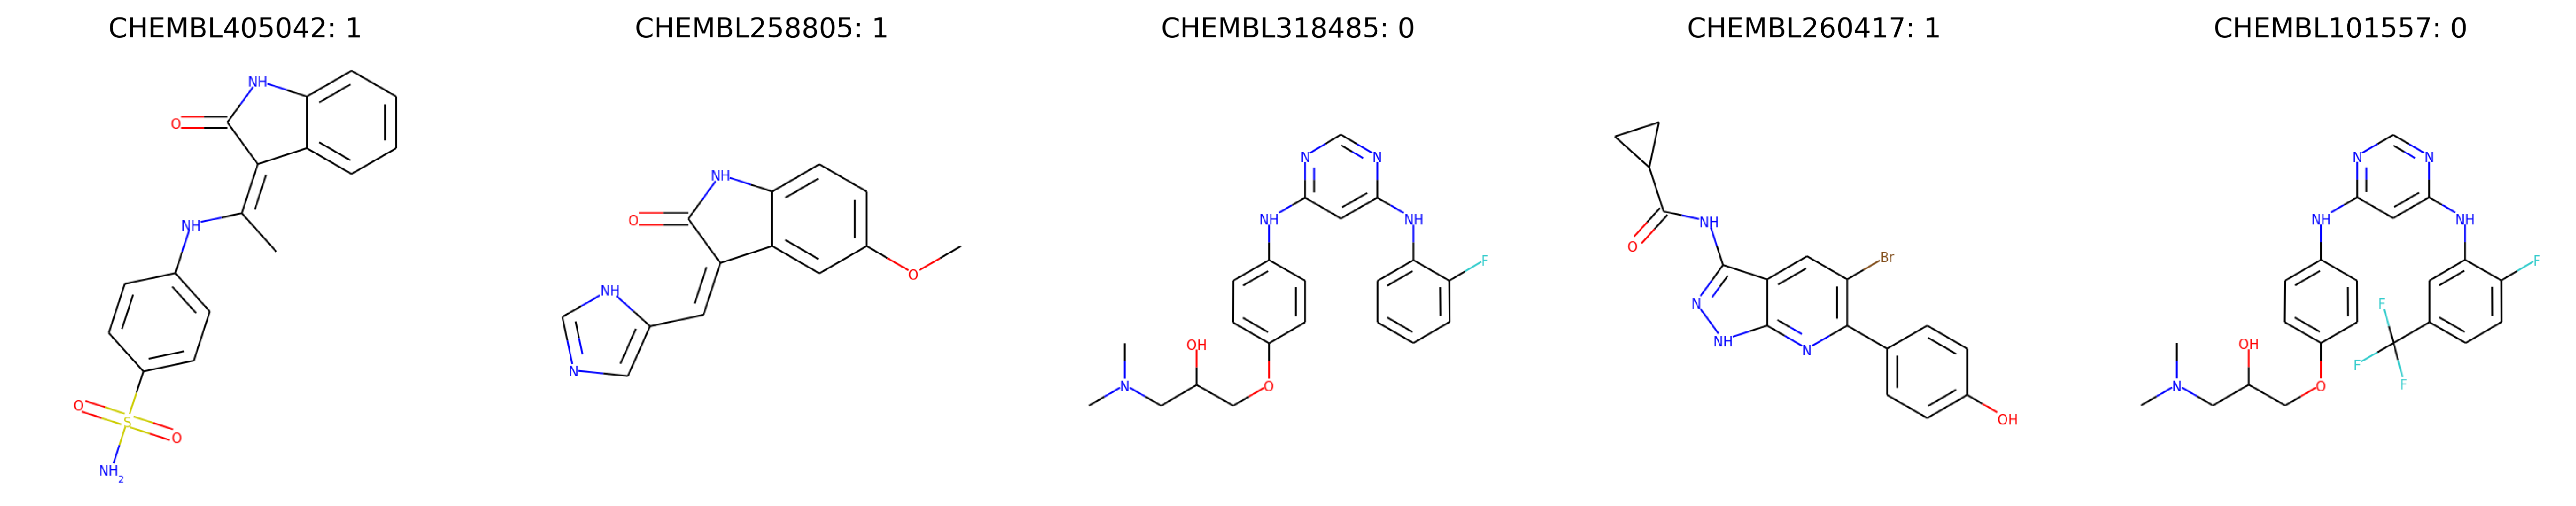

In [18]:
# visualize some molecules
sub = pk_datasets['cdk2'].fetch_subset(start=0, end=5)
display_molecules(sub['chembl_ids'], sub['labels'])

## Section 2: Simple inference scheme
### 2.1. Modeling versus classification

This is a classification problem in which we can the approach of finding the posterior over the weights for a regression; for example, by applying Bayesian logistic regression. However, a more exciting approach would be to model the process that "generated" inhibitor or non-inhibitor molecules and then use test statistics to classify. Approximating the generative process is important for the following reason:
1. We can put constraints on variables in a generative distribution. For example, if producing a certain molecular structure is expensive or has low success rate, we would not want to produce such molecule in real life. Then, we can sample from a truncated distribution that generates inhibitor molecules without unwanted structures and only test inhibitory capabilites of a smaller set of molecules.
2. From the underlying model we can understand better what exactly about those inhibitor molecules that allows them to inhibit a specific protein kinase. With this knowledge, researchers can further investigate binding mechanisms.

### 2.2. Prior and likelihood

Bayesian Poisson factorization

### 2.3. Bayesian Poisson factorization model

In [65]:
# Stan model for Bayesian Poisson factorization
bpf_stan = ''' 

data {
    int<lower=1> num_molec; // number of molecules
    int<lower=1> num_lat_comp; // number of latent components
    int<lower=1> num_feat; // number of features
    
    real<lower=0> alpha_eps; # hyperpriors for latent components
    real<lower=0> beta_eps;
    real<lower=0> alpha_theta;
    
    int<lower=0> obs[num_molec, num_feat]; # feature observations
    real<lower=0> alpha_eta; # hyperpriors for features
    real<lower=0> beta_eta;
    real<lower=0> alpha_beta;
}

parameters {
    real<lower=0> eps;
    vector<lower=0>[num_lat_comp] theta;
    
    vector<lower=0>[num_feat] eta;
    matrix<lower=0>[num_feat, num_lat_comp] beta;
}

model {
    eps ~ gamma(alpha_eps, beta_eps);
    for (i in 1:num_lat_comp)
        theta[i] ~ gamma(alpha_theta, eps);
    
    for (i in 1:num_feat) {
        eta[i] ~ gamma(alpha_eta, beta_eta);
        beta[i] ~ gamma(alpha_beta, eta[i]);
    }
    
    for (i in 1:num_molec)
        for (j in 1:num_feat)
            obs[i, j] ~ poisson(dot_product(theta, beta[j]));
}

'''

bpf_model = pystan.StanModel(model_code=bpf_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3afc2a68cc74dfac0b93df51aa1f25a4 NOW.


In [66]:
sub_data = {
    "num_molec": len(sub['chembl_ids']),
    "num_lat_comp": 1,
    "num_feat": sub['features'].shape[1],
    
    "alpha_eps": 2,
    "beta_eps": 2,
    "alpha_theta": 2,
    
    "obs": sub['features'],
    "alpha_eta": 1,
    "beta_eta": 2,
    "alpha_beta": 2
}

In [ ]:
sub_res = bpf_model.sampling(data=sub_data)

## Section 3: Improved model with molecular features

## References
1. Bhullar, K. S., Lagarón, N. O., McGowan, E. M., Parmar, I., Jha, A., Hubbard, B. P., & Rupasinghe, H. P. V. (2018). Kinase-targeted cancer therapies: progress, challenges and future directions. Molecular Cancer, 17(1). doi:10.1186/s12943-018-0804-2 
2. Gopalan, P., Hofman, J., Blei, D. M. (2014). Scalable Recommendation with Poisson Factorization. Retrieved from https://arxiv.org/pdf/1311.1704.pdf
3. Landrum, G. (2012). Fingerprints in the RDKit. Novartis Institutes for BioMedical Research. Retrieved from https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf
4. Wikipedia contributors (2019). Protein kinase. Retrieved from https://en.wikipedia.org/wiki/Protein_kinase
5. Xiao, K. (2019). Cancer Inhibitors [Dataset]. Retrieved from https://www.kaggle.com/xiaotawkaggle/inhibitors